In [1]:
from models.vae import VAE
from models.rnn import RNN
from models.dnn import DNN


import torch
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import re
import os
import numpy as np
from tqdm import tqdm
from scipy.io import loadmat
import matplotlib.pyplot as plt
from collections import defaultdict
from pandas import DataFrame, concat

In [2]:
seed = 13
# seed = 23
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Path to all dataset
DATASET_PATH = os.path.join(os.getcwd(), 'data')
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.path.join(os.getcwd(), 'checkpoints')

# **DNN Data Generation**

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
Z, RES = defaultdict(dict), defaultdict(dict)
for intensity in tqdm(range(5,10), desc='Reading data ... '):
    ATTACK_DATA_PATH = os.path.join(DATASET_PATH, f'I{intensity}')
    for filename in os.listdir(ATTACK_DATA_PATH):
        fname = os.path.join(ATTACK_DATA_PATH, filename)
        data = loadmat(fname)
        att_type = int(re.findall(r'\d+', filename)[0])
        Z[intensity][att_type] = data['Z']
        RES[intensity][att_type] = data['Res']

NORMAL_DATA_FILENAME = 'Normal2.mat'
data = loadmat(os.path.join(DATASET_PATH, NORMAL_DATA_FILENAME))
Z[0] = data['Z']
RES[0] = data['Res']


Z = dict(sorted(Z.items()))
RES = dict(sorted(RES.items()))

Reading data ... : 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


In [6]:
latent_dim = 118
hidden_size = 100
num_layers = 2
rnn_window = 10
samples = 30

In [7]:
noise_levels = [5, 10, 20, 50]
vaes, rnns = dict(), dict()
for level in noise_levels:
    vae = VAE(latent_dim).to(device)
    vae.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'vae_{level}%.pt')))
    vaes[level] = vae

    rnn = RNN(input_dims=rnn_window * latent_dim,
              outputdims=latent_dim,
              hidden_size=hidden_size,
              num_layers=num_layers).to(device)
    rnn.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'rnn_{level}%.pt')))
    rnns[level] = rnn

dnn = DNN().to(device)
dnn.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, 'dnn_5%.pt')))

<All keys matched successfully>

In [8]:
Res = defaultdict(dict)
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    vae = vaes[level].eval()
    rnn = rnns[level].eval()
    # state estimation residual for normal data
    r1 = torch.tensor(RES[0], dtype=torch.float32)
    z = torch.tensor(Z[0], dtype=torch.float32).to(device)
    R = []
    for _ in range(samples):
        # VAE residuals for normal data
        z_rec = vae(z)
        r2 = (z_rec - z).detach().cpu()

        # rnn prediction residual
        s_t = vae.encoder(z)
        s_t = series_to_supervised(s_t.cpu().detach().numpy(), n_in=rnn_window).values[:,:rnn_window * latent_dim]
        s_t = torch.tensor(s_t, dtype=torch.float32).to(device)
        s_tt = rnn(s_t)
        z_rnn = vae.decoder(s_tt)
        r3 = (z_rnn - z[rnn_window:]).detach().cpu()
        R.append(torch.stack([r1[rnn_window:],r2[rnn_window:],r3], dim=1))
    Res[level][0] = torch.stack(R, dim=1)
    for intensity in range(5,10):
        for k, v in Z[intensity].items():
            # state estimation residual
            r1 = torch.tensor(RES[intensity][k], dtype=torch.float32)
            z = torch.tensor(v, dtype=torch.float32).to(device)
            R = []
            for _ in range(samples):
                # VAE residuals
                z_rec = vae(z)
                r2 = (z_rec - z).detach().cpu()
                
                # rnn prediction residual
                s_t = vae.encoder(z)
                s_t = series_to_supervised(s_t.cpu().detach().numpy(), n_in=rnn_window).values[:,:rnn_window * latent_dim]
                s_t = torch.tensor(s_t, dtype=torch.float32).to(device)
                s_tt = rnn(s_t)
                z_rnn = vae.decoder(s_tt)
                r3 = (z_rnn - z[rnn_window:]).detach().cpu()
                R.append(torch.stack([r1[rnn_window:],r2[rnn_window:],r3], dim=1))
            Res[level][k] = torch.stack(R, dim=1)

 Generating residuals ... : 100%|██████████| 4/4 [04:39<00:00, 69.89s/it]


In [9]:
y = dict()
no_signal = len(Z[0]) - rnn_window
for l in range(4):
    y[l] = F.one_hot(l * torch.ones((no_signal), dtype=torch.long), num_classes=4).float()

# **DNN Evaluation**

In [10]:
preds = defaultdict()
for level, X in Res.items():
    dnn.eval()
    _X = torch.cat(list(X.values()), dim=0).to(device)
    preds[level] = dnn(_X)

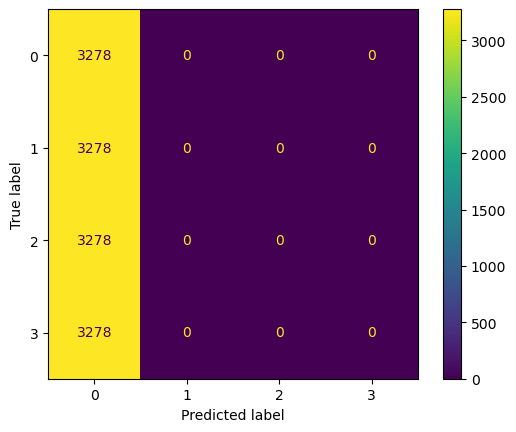

In [11]:
# noise level 5 dataset
pp = torch.argmax(preds[5], dim=1).cpu().detach().numpy()
yy = torch.argmax(torch.cat(list(y.values()), dim=0).long(), dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

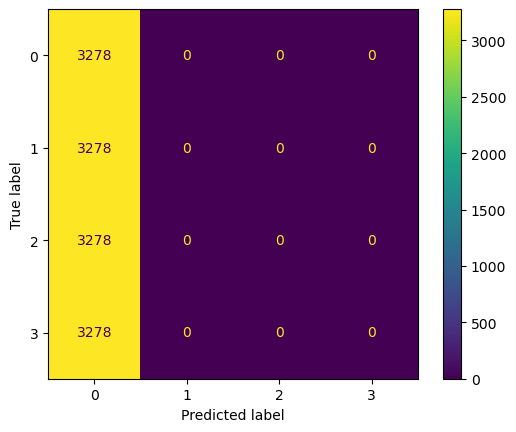

In [12]:
# noise level 10 dataset
pp = torch.argmax(preds[10], dim=1).cpu().detach().numpy()
yy = torch.argmax(torch.cat(list(y.values()), dim=0).long(), dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

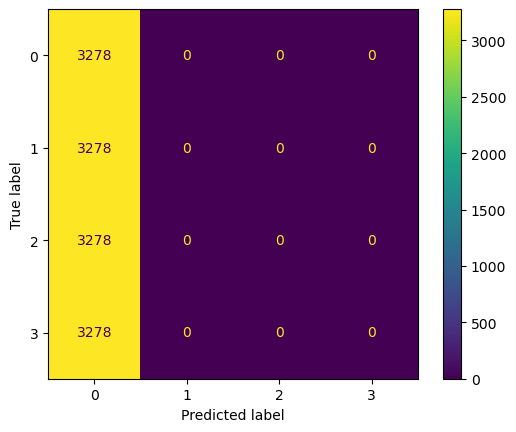

In [13]:
# noise level 20 dataset
pp = torch.argmax(preds[20], dim=1).cpu().detach().numpy()
yy = torch.argmax(torch.cat(list(y.values()), dim=0).long(), dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

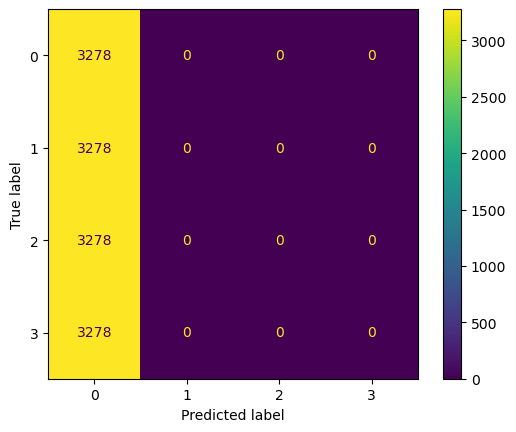

In [14]:
# noise level 50 dataset
pp = torch.argmax(preds[50], dim=1).cpu().detach().numpy()
yy = torch.argmax(torch.cat(list(y.values()), dim=0).long(), dim=1).numpy()
cm = confusion_matrix(yy,pp, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()